### Introduction

This project aims to analyze the first transactions of new wallets in the Ethereum network. For simplicity, the term "new wallets" refers to all addresses, including a small proportion (1%) of smart contracts. The study investigates various aspects of these transactions to provide insights into their nature, gas usage, and associated contract functionality.

***

### Data Collection**

The dataset for this project was retrieved from **Google Cloud** and loaded into a DataFrame (`df`).

#### Description:
- The **population** of new wallets' first outgoing transactions in **2023** contained over **25 million rows**.
- Even a **1% random sample** of the population was substantial in size.
- To make the analysis more manageable, a subset of **20,000 rows** was selected from the 1% sample.

#### Validation of the Sample:
- The sample was validated for representativeness:
  - The percentage of **contract addresses** and **zero-value transactions** in the sample matched the percentages in the full population.
- This confirmed that the sample was statistically reliable for analysis.

#### Note:
- The table `first_transactions_sample_with_input` was previously created using **SQL queries** in **BigQuery**.
- All SQL queries used for this project are saved in the file `BigQueryQueries.md`.

***

### Terminology

#### **Wallet**
   A wallet refers to a unique Ethereum address used by individuals to send, receive, and store cryptocurrency. Wallets can be of two types:
   - **Externally Owned Accounts (EOA)**: Controlled by private keys, used by regular users.
   - **Contract Accounts**: Smart contracts deployed on the Ethereum blockchain with their own address.
#### **Transaction**
   A transaction is a recorded action on the Ethereum blockchain, such as transferring cryptocurrency or interacting with a smart contract. 
#### **Transaction Types in Ethereum**
Ethereum supports three main transaction types, each with its own characteristics and improvements:
1. **Type 0 (Legacy Transactions)** - offers simplicity but lacks efficiency in dynamic fee adjustments.
2. **Type 1 (EIP-2930 Access List Transactions)** - useful for smart contract interactions with predefined storage.
3. **Type 2 (EIP-1559 Transactions)** - enhances user experience with more predictable fees and improved scalability.
#### **Gas**
   Gas is a unit of measurement representing the computational effort required to execute operations on the Ethereum network. Key terms include:
   - **Estimated Gas**: The pre-calculated amount of gas required to execute a transaction.
   - **Used Gas**: The actual amount of gas consumed during transaction execution.
   - **Gas Price**: The amount a user is willing to pay per unit of gas, typically measured in Gwei.
#### **Smart Contract**
   A smart contract is a self-executing program stored on the Ethereum blockchain. It automates actions like fund transfers, token issuance, or decentralized application logic.
#### **Stablecoin**
   A type of cryptocurrency pegged to the value of a stable asset, such as the US dollar. Examples include USDT (Tether) and USDC (USD Coin).
#### **Token (NFT)**
   Tokens are assets created on top of the Ethereum blockchain. Non-Fungible Tokens (NFTs) represent unique digital items, such as artwork or collectibles.
#### **Top Contract Addresses**
   Frequently used contract addresses that often serve as destinations for transactions. They can represent various functionalities like stablecoins, decentralized exchanges (DEX), or NFT platforms.
#### **Wei**:
   - The smallest unit of Ether.
   - 1 Ether = **10¹⁸ Wei**.
   - Values in the dataset, such as `value`, are typically stored in Wei for precision.
#### **Ether (ETH)**:
   - The primary currency used on the Ethereum blockchain.
   - Used for transactions, gas fees, and smart contract interactions.
   - To convert Wei to Ether: divide by **10¹⁸** (e.g., `1 ETH = 1,000,000,000,000,000,000 Wei`).

***

#### Key Steps:
1. **Data Collection**:
   - Identified the first transactions from all newly created wallets (25,270,041 transactions in total).
   - Selected a random sample of 20,000 transactions for detailed analysis.
2. **Transaction Classification**:
   - Categorized transactions by their direction:
     - **Wallet-to-Wallet**: Transfers between regular wallets (users).
     - **Wallet-to-Contract**: Transfers from wallets to smart contracts.
     - **Contract**: Transfers from contracts.
3. **Transaction Size Analysis**:
   - Explored the size and volume of these transactions, focusing on gas usage and its distribution.
4. **Gas Usage Analysis**:
   - Compared **estimated gas** (pre-transaction calculation) with **actual gas used** to evaluate efficiency across transaction types.
5. **Transaction Types**:
    - Determined the transaction types (Type 0, Type 1, Type 2) used for sending these transfers.
7. **Top-25 Contract Addresses**:
   - Identified the top 25 most frequently targeted contract addresses.
   - Classified these contracts based on their functionality, including stablecoins, NFTs, DeFi, and others.
8. **Statistical Analysis**:
   - Conducted a statistical test that revealed systematic overestimation of gas by stablecoin contracts compared to other contract categories.

This project provides a detailed understanding of Ethereum's transaction dynamics, focusing on gas usage patterns and the functional behavior of smart contracts.


### Column Descriptions

Below is an explanation of the columns used in this project:

### Column Descriptions

Below is an explanation of the columns used in the dataset:

1. **`from_address`**:
   - The Ethereum address initiating the transaction.
   - Represents either a wallet (EOA) or a smart contract.
2. **`first_transaction_time`**:
   - The timestamp of the first transaction sent by the address.
3. **`to_address`**:
   - The recipient Ethereum address.
   - Can be another wallet or a smart contract.
4. **`value`, wei**:
   - The amount of Ether transferred in the transaction, measured in Wei.
   - A value of `0` often indicates interactions with contracts without transferring funds.
5. **`input`**:
   - The data payload sent with the transaction, typically used for contract interactions.
   - For example, it may contain encoded parameters for a contract function.
6. **`gas`**:
   - The maximum amount of gas the sender is willing to pay for the transaction.
   - Represents the estimated computational cost.
7. **`gas_price`**:
   - The price per unit of gas, measured in Gwei.
   - Determines the total transaction fee along with the gas used.
8. **`transaction_type`**:
   - The type of transaction (0, 1 or 2)
9. **`receipt_gas_used`**:
   - The actual amount of gas consumed during the transaction.
   - Provides insight into the efficiency of the transaction compared to the estimated gas.


### **1. Import all neccessery libraries.**

In [1]:
import calendar
import json
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from google.cloud import bigquery
from matplotlib.colors import to_rgba
from scipy.stats import mannwhitneyu, norm


### **2. Data Collection**

#### Note:
- The table `first_transactions_sample_with_input` was previously created using **SQL queries** in **BigQuery**.
- All SQL queries used for this project are stored in the file `query_ethereum_project.txt`.


In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'my-project-444222-1be5aecf7dbb.json'

In [3]:
client = bigquery.Client()

query = """
SELECT *
FROM `my-project-444222.wallets_2023.first_transactions_sample_with_input`
"""
df = client.query(query).to_dataframe()

### **3. DataFrame Inspection**

The dataset was loaded into a DataFrame with the following structure:


In [4]:
df.head(5)

,from_address,first_transaction_time,to_address,value,input,gas,gas_price,transaction_type,receipt_gas_used
0,0x6475e88ef19683a1345866398f45ab2549dbd621,2023-01-20 23:53:23+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0E-9,0xa9059cbb000000000000000000000000bb3fd383d1c5...,63429,25123969051,0,43725
1,0x49a64a902c99bf44e159d17a8b334d0c054dc612,2023-11-04 02:29:35+00:00,0xdef1c0ded9bec7f1a1670819833240f027b25eff,2718019107674500.000000000,0x3598d8ab000000000000000000000000000000000000...,171677,13626377233,2,140381
2,0xa6481f04f959be573f85bafa962dd5716c75036f,2023-02-13 07:51:59+00:00,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,0E-9,0xa9059cbb000000000000000000000000c610ff51929c...,316657,14899917470,2,226075
3,0x8f0ab55f38f530345d271600eb3c0d08c1df19df,2023-06-12 12:18:11+00:00,0x8e16bf47065fe843a82f4399baf5abac4e0822b7,0E-9,0xa9059cbb000000000000000000000000c30badb28e20...,62243,15750000000,0,56963
4,0x92508951402cf163ace0e23424b1d888e13c093b,2023-09-14 13:06:59+00:00,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0E-9,0xa9059cbb0000000000000000000000001689a089aa12...,170000,33000000000,0,43701


In [5]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   from_address            20000 non-null  object             
 1   first_transaction_time  20000 non-null  datetime64[us, UTC]
 2   to_address              19867 non-null  object             
 3   value                   20000 non-null  object             
 4   input                   20000 non-null  object             
 5   gas                     20000 non-null  Int64              
 6   gas_price               20000 non-null  Int64              
 7   transaction_type        20000 non-null  Int64              
 8   receipt_gas_used        20000 non-null  Int64              
dtypes: Int64(4), datetime64[us, UTC](1), object(4)
memory usage: 1.4+ MB


(None, (20000, 9))

### Column Adjustments

#### `to_address`:
- **Description from the original BigQuery table**:
  > "STRING - NULLABLE - Address of the receiver. NULL when it’s a contract creation transaction."
- **Interpretation**:
  - Rows with a `NULL` value in the `to_address` column indicate a **contract creation transaction**.
- **Action Taken**:
  - Replaced all `NULL` values in the `to_address` column with the string `'Contract'` for clarity.

#### `value`:
- **Initial State**:
  - Stored as an **object**.
- **Action Taken**:
  - Converted the `value` column to a **numeric type** to enable further analysis of transaction amounts.
 
#### `transaction_type`:
- **Initial State**:
  - Stored as an **integer**.
- **Action Taken**:
  - Converted the `transaction_type` column to a **string** type, as it represents a categorical variable (e.g., Type 0, Type 1, Type 2).
    

In [6]:
df = df.fillna('Contract')
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['transaction_type'] = df['transaction_type'].astype('str')

### **4. Extract Bytes Signatures from Input and Decode Them**

#### Key Concepts:
- **Bytes Signature**:
  - The **first 10 symbols** of the `input` column in a transaction.
  - Represents a unique identifier of the function being called in a smart contract.
  - Can be decoded into a **readable text signature**, which provides the name of the function being executed.
- **Function**:
  - The specific action that a smart contract executes when called.
  - Examples: `transfer(address,uint256)`, `approve(address,uint256)`.
- **Smart Contract**:
  - A self-executing program on the Ethereum blockchain that automates predefined actions based on the transaction input.
    
#### Special Case:
- If the **Bytes Signature** is `0x`:
  - This indicates that the transaction does not involve a smart contract.
  - Such transactions are classified as **Transfers** (direct transfers between two wallets).

#### Actions Taken:
1. Extracted the first 10 symbols from the `input` column and saved them as **Bytes Signatures**.
2. Decoded these signatures into their corresponding **Function Names** using a decoding library or API (e.g., [4byte.directory](https://www.4byte.directory/)).
3. Classified transactions:
   - **Transfers** (if signature is `0x`).
   - **Smart Contract Interactions** (if a valid signature is present).

This step allows us to distinguish simple wallet-to-wallet transactions from more complex interactions involving smart contracts.


#### 4.1 **Extract Bytes Signatures**:
   - Extracted the **first 10 symbols** from the `input` column to create a new column, `signature`:
   - Identified unique byte signatures using:
   - Analyzed the frequency of the top 5 most common signatures:

In [7]:
df['signature'] = df['input'].str[:10]
unique_signatures = df['signature'].unique()
df['signature'].value_counts().head(5)

signature
0x            8770
0xa9059cbb    5087
0x095ea7b3     974
0xeb672419     859
0x3593564c     401
Name: count, dtype: int64

#### 4.2 **Decode Function Names**:

In [8]:
def get_function(signature_list):
    """
    Decodes a list of Ethereum function signatures using the 4byte.directory API.

    Args:
        signature_list (list): List of hexadecimal function signatures (e.g., ['0x095ea7b3']).

    Returns:
        dict: A dictionary mapping each signature to its decoded function name or 'Unknown'.
    """
    decoded = {}
    for signature in signature_list:
        if signature == '0x':
            decoded[signature] = 'Transfer'
            continue 
        url = f"https://www.4byte.directory/api/v1/signatures/?hex_signature={signature}"
        response = requests.get(url)
        if response.status_code == 200:
            results = response.json().get('results', [])
            decoded[signature] = results[0]['text_signature'] if results else "Unknown"
        else:
            decoded[signature] = "API error"
    return decoded


In [9]:
decoded_results = get_function(unique_signatures)
df['function'] = df['signature'].map(decoded_results)
df.function.value_counts().head(5)

function
Transfer                                                                       8770
workMyDirefulOwner(uint256,uint256)                                            5087
_SIMONdotBLACK_(int8[],int224[],int256,int64,uint248[])                         974
requestL2Transaction(address,uint256,bytes,uint256,uint256,bytes[],address)     859
Unknown                                                                         838
Name: count, dtype: int64

#### 4.3 **Collision in Bytes Code**:
   - Observed unexpected function names due to **collision in Bytes Code** (when different functions produce the same byte signature).
   - Verified the signatures manually using [4byte.directory](https://www.4byte.directory/).
   - Updated incorrect function names using a custom function:

In [10]:
def fixed_func_names(func_name):
    """
    Corrects specific function names caused by signature collisions or decoding issues.
    
    Args:
        func_name (str): The original function name from decoding.

    Returns:
        str: The corrected function name if a match is found; otherwise, the original name.
    """
    if func_name == 'workMyDirefulOwner(uint256,uint256)':
        return 'transfer(address,uint256)'
    elif func_name == '_SIMONdotBLACK_(int8[],int224[],int256,int64,uint248[])':
        return 'approve(address,uint256)'
    elif func_name == 'join_tg_invmru_haha_9f4805a(bool,uint256)':
        return 'swapExactETHForTokensSupportingFeeOnTransferTokens(uint256,address[],address,uint256)'
    return func_name

df['function'] = df['function'].apply(fixed_func_names)

#### Final Adjustments:
- Replaced incorrect function names to ensure accuracy in the dataset.
- This step ensures that the **function column** contains meaningful and correct function names for further analysis.

In [11]:
df.function.value_counts().head(5)

function
Transfer                                                                       8770
transfer(address,uint256)                                                      5087
approve(address,uint256)                                                        974
requestL2Transaction(address,uint256,bytes,uint256,uint256,bytes[],address)     859
Unknown                                                                         838
Name: count, dtype: int64

### Function Analysis

#### Summary of Most Common Functions:
The top functions decoded from the dataset are as follows:

#### Interpretation:
- The **Transfer** function (8,770 occurrences) represents transactions between **Externally Owned Accounts (EOA)** . These are simple Ether transfers without interaction with smart contracts.
- Other functions, such as `transfer(address,uint256)` and `approve(address,uint256)`, are associated with **smart contracts** or **inner blockchain processes**, indicating more complex interactions.

#### Conclusion:
- Excluding **8,770 Transfers**, all other transactions in the dataset involve interactions with **smart contracts** or **internal blockchain mechanisms**.
- This suggests a significant portion of Ethereum activity is driven by contract interactions rather than simple wallet transfers.


### **5. Analysis of the First Transactions Purposes**

#### Excluding Contract Addresses:
After filtering out transactions involving contract addresses, the dataset was analyzed for  transfers. Below is the summary of the key metrics:

In [12]:
df[df['function'] == 'Transfer'].describe()

,value,gas,gas_price,receipt_gas_used
count,8.770000e+03,8770.0,8770.0,8770.0
mean,9.822688e+18,27576.715165,32202855570.149033,21320.169555
std,4.918961e+20,30545.965764,29711920906.699932,5236.021528
min,0.000000e+00,21000.0,4740000000.0,21000.0
25%,2.074420e+16,21000.0,17000000000.0,21000.0
50%,6.364410e+16,21000.0,25001539939.5,21000.0
75%,2.356489e+17,21000.0,38000000000.0,21000.0
max,3.131060e+22,978136.0,1176000000000.0,270353.0


The dataset contains heterogeneous data, including transactions with a **value of 0.00 ETH**. This raised the question:  
**Why would someone send 0 ETH if it is NOT a contract-related transaction?**

#### 5.1. How Many Zero Transactions Among User Transfers?

In [13]:
df[(df['function'] == 'Transfer') & (df['value'] == 0.00)].shape[0]

92

**92 transactions** in the dataset had a `value` of 0 ETH, classified as Transfers, mean they belong **Externally Owned Accounts (EOA)**: Controlled by private keys, used by regular users. 

#### 5.2. Detailed Analysis of Transfers with 0 ETH:
Transfers are typically categorized as Externally Owned Accounts (EOA) transactions (due to a zero `input`). However, further investigation revealed that some zero-value transactions might still involve contracts. 

In [14]:
df[(df['function'] == 'Transfer') & (df['value'] == 0.00)].to_address.value_counts().head(3)

to_address
0xb6b039afc0ce83ddf613d6b742eba3b96943df0e    30
0x2b82c78ae3c973c1ce39d63b5d63c6cb8db199ea    18
0x34806cbba5698f9ca9f4aa4700348e56fe3ceb34     8
Name: count, dtype: int64

##### Findings:
1. **Recipient Address Check**:
   - The two most frequent recipient addresses of zero-value transfers were manually checked on **Etherscan**:
     - [1st address (30 transactions)](https://etherscan.io/address/0xb6b039afc0ce83ddf613d6b742eba3b96943df0e)
     - [2nd address (18 transactions)](https://etherscan.io/address/0x2b82c78ae3c973c1ce39d63b5d63c6cb8db199ea)
   - Results: Both addresses were identified as belonging to **contracts**. Despite the zero `input` and zero `value`, these transactions interacted with the blockchain.

2. **Additional Analysis**:
   - A detailed review of **48 transactions** with a `value` of 0 ETH confirmed that **all of them were directed to contracts**.
   - Therefore, it is reasonable to assume that the remaining transactions in this group (92 total) are also contract-related.

---

#### Conclusion:
- While a **zero input** is often used to classify transactions as transactions between **Externally Owned Accounts (EOA)**, this criterion is not always accurate.
- Some transactions with zero `input` and zero `value` still interact with contracts, performing specific functions that may not involve Ether transfer.
- To improve classification accuracy:
  - Perform additional checks on recipient addresses.
  - Identify typical patterns in contract-related transactions.

This approach helps avoid misclassification and provides a clearer understanding of blockchain interactions.

#### 5.3 Categorizing Transactions by Purpose

#### Purpose Classification:
To better understand the nature of transactions, they were categorized based on their destination and function:

1. **Categories**:
   - **Contract**: Transactions initiated by contracts themselves, where the contract acts as the `from_address`.
   - **Wallet-to-Wallet**: Direct transfers between wallets, excluding contract involvement.
   - **Wallet-to-Contract**: Transactions interacting with contracts but not classified as direct transfers.

In [15]:
def transfer_or_contract(row):
    """
    Categorizes a transaction by its purpose based on recipient and function.

    Args:
        row (pd.Series): A single row of the DataFrame containing transaction details.

    Returns:
        str: The purpose of the transaction, categorized as:
             - 'Contract' for transactions creating or interacting with contracts.
             - 'Wallet-to-Wallet' for direct transfers between user wallets.
             - 'Wallet-to-Contract' for interactions with contracts that are not classified as transfers.
    """
    if row['to_address'] == 'Contract':
        return 'Contract'
    elif row['function'] == 'Transfer' and row['value'] != 0.00 and row['to_address'] != 'Contract':
        return 'Wallet-to-Wallet'    
    return 'Wallet-to-Contract'

**Pie Chart:**  
The pie chart below illustrates the percentage distribution of transaction purposes:

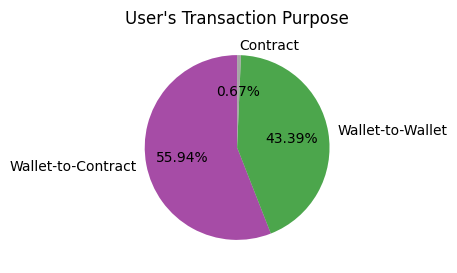

In [16]:
df['transactions_purpose'] = df.apply(transfer_or_contract, axis=1)

transactions_destination_percenrtage = df['transactions_purpose'].value_counts(normalize=True) * 100

plt.figure(figsize=(3, 3))
colors = [to_rgba("purple", alpha=0.7), to_rgba("green", alpha=0.7), to_rgba("grey", alpha=0.7)]
transactions_destination_percenrtage.plot(kind="pie", colors=colors, autopct="%.2f%%", startangle=90)
plt.title("User's Transaction Purpose")
plt.ylabel("")
plt.show()

#### Results:
The distribution of transaction purposes is as follows:

- **Wallet-to-Contract**: 55.94% of the transactions fall into this category, where users send funds to contract addresses.
- **Wallet-to-Wallet**: 43.39% of the transactions involve direct transfers between users.
- **Contract**: Only 0.67% of the transactions are initiated by contract addresses.

#### Key Insights:
- **Wallet-to-Contract interactions dominate** the dataset, indicating that most new accounts are created to interact with smart contracts.
- A **significant portion** of transactions (43.39%) represent simple wallet-to-wallet transfers, highlighting the role of new accounts in facilitating direct user interactions.
- **Contract-initiated transactions** are relatively rare, comprising only 0.67% of the total, suggesting that new contracts are less likely to initiate transactions immediately after creation.

#### Conclusion:
These findings represent the **first outgoing transactions** of newly created accounts, showing a clear trend:
- **Majority** of new accounts are used to interact with contract addresses.
- **User-to-user transfers** still make up a substantial share.
- Contract-initiated activity remains an outlier among new accounts.

### **6. What is the Median Value for Transactions?**

#### **6.1 Wallet-to-Wallet Transactions**

In [17]:
wallet_to_wallet_median_value = df[df['transactions_purpose'] == 'Wallet-to-Wallet'].value.median() 

**For value in ETH divide user_to_user_median_value by 10^18**

In [18]:
wallet_to_wallet_median_value_ETH = round((wallet_to_wallet_median_value / 10**18), 4)
wallet_to_wallet_median_value_ETH

np.float64(0.0653)

#### **Median Value for Wallet-to-Wallet Transactions: 0.653 ETH**

#### **6.2 Contract Transactions.**

In [19]:
contract_median_value_ETH = round((df[df['transactions_purpose'] == 'Wallet-to-Contract'].value.median() / 10**18), 4)
contract_median_value_ETH

np.float64(0.0)

##### **Medina Value for Wallet-to-Contract Transactions is 0.0 ETH**  
#### **Insights:**
- A significant portion of transactions to contracts does not involve Ether transfers. These are typically instructional transactions, where users send commands or invoke functions on smart contracts.
- Examples include:
    - Token operations (e.g., approvals, minting, or burning).
    - Interacting with DeFi platforms (e.g., staking or exchanging tokens).
    - NFT operations (e.g., metadata updates or minting).

This highlights the multi-functional role of smart contracts in the Ethereum network, where transactions are often not financial but operational in nature.

### **7. Monthly Trends in New Account Activity**

#### Objective:
Analyze the monthly trends in the first transactions of newly created wallets, distinguishing between wallet-to-wallet and wallet-to-contract transactions.

#### Methodology:
1. Grouped transactions by:
   - **Month**.
   - **Transaction Purpose** (Wallet-to-Wallet or Wallet-to-Contract).
2. Calculated the total number of first transactions per month for each category.
3. Added a **Total** column to represent the sum of all transactions across categories for each month.

#### Visualization:
A line chart was generated to display:
- **Wallet-to-Contract Transactions**: Represented by the purple line.
- **Wallet-to-Wallet Transactions**: Represented by the green line.
- **All Transactions Combined**: Represented by the orange line.

In [20]:
df['first_transaction_time'] = pd.to_datetime(df['first_transaction_time'])

transactions_per_month = (
    df[['first_transaction_time', 'from_address', 'transactions_purpose']]
    .groupby([df['first_transaction_time'].dt.month, 'transactions_purpose'])['from_address']
    .count()
    .reset_index()
)

transactions_per_month = transactions_per_month.sort_values(by='first_transaction_time')

transactions_per_month['first_transaction_time'] = (
    transactions_per_month['first_transaction_time']
    .apply(lambda x: calendar
    .month_abbr[x])
)
transactions_per_month['total'] = transactions_per_month.groupby('first_transaction_time')['from_address'].transform('sum')

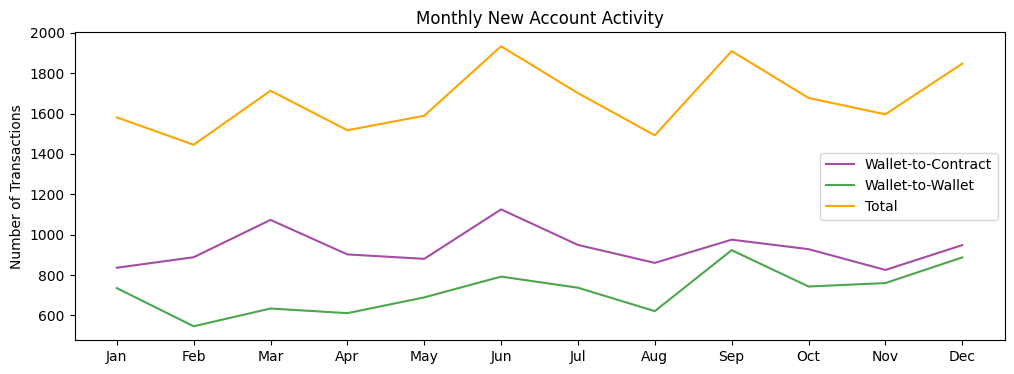

In [21]:
plt.figure(figsize=(12, 4))

wallet_to_contract = transactions_per_month[transactions_per_month['transactions_purpose'] == 'Wallet-to-Contract']
wallet_to_wallet = transactions_per_month[transactions_per_month['transactions_purpose'] == 'Wallet-to-Wallet']

plt.plot(wallet_to_contract['first_transaction_time'], wallet_to_contract['from_address'],
         label='Wallet-to-Contract', color='purple', alpha=0.7)
plt.plot(wallet_to_wallet['first_transaction_time'], wallet_to_wallet['from_address'],
         label='Wallet-to-Wallet', color='green', alpha=0.7)
plt.plot(transactions_per_month['first_transaction_time'], transactions_per_month['total'],
         label='Total', color='orange')

plt.title('Monthly New Account Activity')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show();

#### **The x-axis shows the **months**, and the y-axis represents the number of transactions.**

#### Insights from the Graph:
The graph illustrates the monthly creation of new wallets across three categories: **Wallet-to-Contract**, **Wallet-to-Wallet**, and **Total Transactions**.

- **Wallets-to-Contract**. The creation of contract wallets **strongly influences the overall trend**.
Fluctuations in this category are relatively consistent throughout the year.

- **Wallet-to-Wallet** transactions exhibit **sharper variations** compared to Wallets-to-Contract.
Peaks in user-to-user activity (e.g., in **September**) significantly contribute to the total trend.

- **Total Wallet Creation**:
   - The overall trend **closely mirrors Wallets-to-Contract creation**, highlighting its dominant role.
   - However, **spikes in user-to-user wallet activity** during high-activity months (e.g., September) visibly impact the total.

#### Conclusion:
Wallets-to-Contract creation is the **primary driver** of the total trend, reflecting consistent growth across the year. At the same time, Wallet-to-Wallet make **notable contributions** during specific months of heightened activity, emphasizing their role in shaping short-term variations in overall wallet creation.

### **8. What is the Values Distribution of Transactions by Category?**

#### Categories:
Transactions were grouped into the following categories based on their Ether (ETH) value:
- **Zero**: Transactions with 0 ETH (e.g., `value = 0.0` ETH).
- **Micro**: Transactions with very small amounts (e.g., `< 0.001 ETH`).
- **Small**: Transactions with small amounts (e.g., `0.001 to 0.1 ETH`).
- **Medium**: Transactions with medium amounts (e.g., `0.1 to 1 ETH`).
- **Large**: Transactions with large amounts (e.g., `1 to 10 ETH`).
- **Whale**: Transactions with very large amounts (e.g., `> 10 ETH`).

#### Methodology:
1. **Converted Wei to Ether**:
   - A new column `eth_value` is created by converting `value` from Wei to ETH.
2. **Categorized Transactions**:
   - Used **bins** to assign transactions to the above categories based on `eth_value`.
3. **Normalized for Percentages**:
   - Calculated the percentage distribution of each category by transaction type (e.g., Wallet-to-Wallet, Wallet-to-Contract).
4. **Plotted the Data**:
   - Created a **bar chart** to visualize the value distribution by category for:
     - All Transactions.
     - Wallet-to-Contract Transactions.
     - Wallet-to-Wallet Transactions.


In [22]:
df['eth_value'] = df['value'] /1e18

df['value_category'] = 'Zero'

bins = [0, 0.001, 0.01, 0.1, 1, 10, float('inf')]
labels = ['Micro', 'Small', 'Medium', 'Large', 'Whale', 'Mega Whale']

df.loc[df['eth_value'] > 0, 'value_category'] = pd.cut(
    df['eth_value'], bins=bins, labels=labels
)

In [23]:
general_value_category_perc = df['value_category'].value_counts(normalize=True) * 100

wallet_to_wallet_value_category_perc = (
    df[df['transactions_purpose'] == 'Wallet-to-Wallet']['value_category']
    .value_counts(normalize=True) * 100
)

wallet_to_contract_value_category_perc = (
    df[df['transactions_purpose'] == 'Wallet-to-Contract']['value_category']
    .value_counts(normalize=True) * 100
)

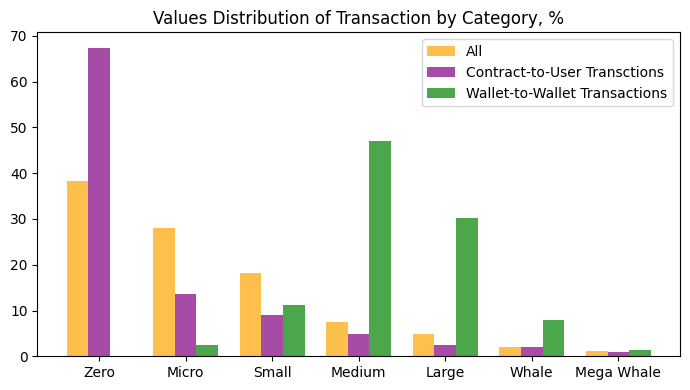

In [24]:
categories = ['Zero', 'Micro', 'Small', 'Medium', 'Large', 'Whale', 'Mega Whale']

index = np.arange(len(categories))
bar_width = 0.25  

wallet_to_wallet_value_category_perc = (
    wallet_to_wallet_value_category_perc
    .reindex(categories, fill_value=0)
)

plt.figure(figsize=(7, 4))

plt.bar(index - bar_width, general_value_category_perc, bar_width,
        label='All', color='orange', alpha=0.7)
plt.bar(index, wallet_to_contract_value_category_perc, bar_width,
        label='Contract-to-User Transctions', color='purple', alpha=0.7)
plt.bar(index + bar_width, wallet_to_wallet_value_category_perc, bar_width,
        label='Wallet-to-Wallet Transactions', color='green', alpha=0.7)


plt.xticks(index, categories)
plt.title('Values Distribution of Transaction by Category, %')
plt.legend()

plt.tight_layout()
plt.show()

#### Insights:
- **Zero Transactions** dominate Wallet-to-Contract interactions, representing non-financial operations (e.g., function calls or token operations).
- **Micro and Small Transactions** are more frequent in the "All Transactions" category, indicating regular small-value transfers.
- **Large and Whale Transactions** are predominantly found in Wallet-to-Wallet transfers, showing that users often transfer significant amounts directly to one another.

#### Conclusion:
This analysis highlights the differing purposes of transactions based on value:
- **Wallet-to-Contract Transactions** often involve zero-value instructions rather than monetary tran


### **9. Gas Usage Analysis**

#### **9.1 Estimated Gas**
The median gas limit set for each transaction category:


In [25]:
gas_median_wallet_to_wallet = df[df['transactions_purpose'] == 'Wallet-to-Wallet'].gas.median()
print(f'Gas Median for Wallet-to-Wallet Transaction is {gas_median_wallet_to_wallet}')

gas_median_wallet_to_contract = df[df['transactions_purpose'] == 'Wallet-to-Contract'].gas.median()
print(f'Gas Median for Wallet-to-Contract Transaction is {gas_median_wallet_to_contract}')

gas_median_contract = df[df['transactions_purpose'] == 'Contract'].gas.median()
print(f'Gas Median for Contract Transaction is {gas_median_contract}')

Gas Median for Wallet-to-Wallet Transaction is 21000.0
Gas Median for Wallet-to-Contract Transaction is 92218.0
Gas Median for Contract Transaction is 2131637.0


1. **Wallet-to-Wallet Transactions**:
   - **Estimated Gas**: 21,000
   - These transactions represent the most basic Ethereum operations, typically involving simple ETH transfers between users. The gas usage is fixed and predictable due to the absence of complex computations.

2. **Wallet-to-Contract Transactions**:
   - **Estimated Gas**: 92,218
   - These transactions involve interactions with smart contracts. The higher estimated gas reflects the potential complexity of contract functions, such as branching, loops, or computations.

3. **Contract Transactions**:
   - **Estimated Gas**: 2,131,637
   - These transactions are initiated by smart contracts themselves and involve complex operations, such as interacting with other contracts or executing multiple steps. The high gas estimate ensures sufficient resources for execution.

#### **9.2 Used Gas**
The median actual gas used for each transaction category:

In [26]:
used_gas_median_wallet_to_wallet = df[df['transactions_purpose'] == 'Wallet-to-Wallet'].receipt_gas_used.median()
print(f'Used Gas Median for Wallet-to-Wallet Transaction is {used_gas_median_wallet_to_wallet}')

used_gas_median_wallet_to_contract = df[df['transactions_purpose'] == 'Wallet-to-Contract'].receipt_gas_used.median()
print(f'Used Gas Median for Wallet-to-Contract Transaction is {used_gas_median_wallet_to_contract}')

used_gas_median_contract = df[df['transactions_purpose'] == 'Contract'].receipt_gas_used.median()
print(f'Used Gas Median for Contract Transaction is {used_gas_median_contract}')

Used Gas Median for Wallet-to-Wallet Transaction is 21000.0
Used Gas Median for Wallet-to-Contract Transaction is 48897.0
Used Gas Median for Contract Transaction is 1984655.0


1. **Wallet-to-Wallet Transactions**:
   - **Used Gas**: 21,000
   - The gas usage matches the estimated value, reflecting the simplicity and predictability of these transactions.

2. **Wallet-to-Contract Transactions**:
   - **Used Gas**: 48,897
   - While the estimated gas is higher, the actual gas used is significantly lower. This discrepancy highlights that most interactions involve straightforward function calls, such as token transfers, which require less computation than initially estimated.

3. **Contract Transactions**:
   - **Used Gas**: 1,984,655
   - These transactions remain highly resource-intensive due to the multitasking nature of contracts, including interacting with other contracts, executing loops, and managing datasets. However, the used gas is slightly lower than the estimate, indicating optimized execution.

#### **Difference Between Estimated and Used Gas**
- **Why the Difference?**:
  - Estimated gas is calculated for the **worst-case scenario**, ensuring the transaction has enough gas to succeed.
  - Used gas reflects the **actual operations** performed, which are often simpler than the estimated logic, leading to lower consumption.
  - This approach ensures reliability, avoiding transaction failures due to underestimation.

#### **Conclusion**:
Gas usage increases with transaction complexity:
- **Wallet-to-Wallet Transfers**: Predictable and fixed gas usage.
- **Wallet-to-Contract Calls**: Moderate gas usage for contract interactions.
- **Contract Transactions**: The highest gas usage due to the complex, multitasking nature of contract execution.

### **10. Gas Usage Difference**

#### Methodology:
1. Calculated the **Gas Difference** as the difference between `gas` (estimated gas) and `receipt_gas_used` (used gas):
2. Binned the gas difference values into defined ranges:
   Ranges: 0, 0-10k, 10k-50k, 50k-100k, 100k-500k, 500k+.
4. Normalized the data to represent percentages of transactions in each range per transaction purpose.
5. Created a stacked bar chart to visualize the distribution of gas differences by transaction purpose.


In [27]:
df['gas_difference'] = df['gas'] - df['receipt_gas_used']

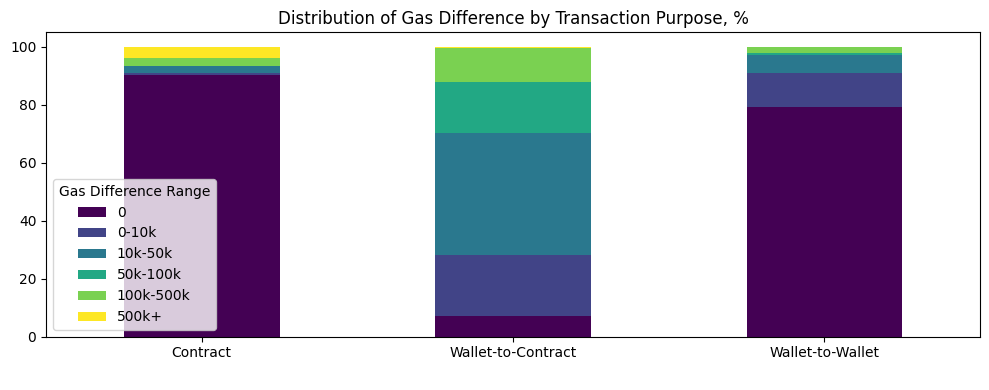

In [28]:
bins = [-1, 0, 10_000, 50_000, 100_000, 500_000, df['gas_difference'].max()]
labels = ['0', '0-10k', '10k-50k', '50k-100k', '100k-500k', '500k+']
df['gas_diff_bins'] = pd.cut(df['gas_difference'], bins=bins, labels=labels)

percentage_data = df.groupby(['transactions_purpose', 'gas_diff_bins'],observed=False).size().unstack(fill_value=0)
percentage_data = percentage_data.div(percentage_data.sum(axis=1), axis=0) * 100

percentage_data.plot(kind='bar', stacked=True, figsize=(10, 4), colormap="viridis")
plt.title('Distribution of Gas Difference by Transaction Purpose, %')
plt.xlabel(' ')
plt.xticks(rotation=0)
plt.legend(title='Gas Difference Range')
plt.tight_layout()
plt.show()

#### Results:
- **Contract Transactions:**
Nearly all transactions have no gas difference (0).
This indicates that estimated and used gas are closely aligned, reflecting the high predictability of contract-initiated tasks.

- **Wallet-to-Contract Transactions:**
Show significant variability in gas differences:
    - Large portions fall within the ranges 10k-50k and 50k-100k.
    - Only a small percentage have no gas difference, highlighting the complexity of contract executions.

- **Wallet-to-Wallet Transactions:**
    - The majority of transactions have no gas difference, consistent with the simplicity of these operations.
    - Small differences (0-10k) occasionally occur due to minor adjustments in execution.

#### Key Insight:
**Gas Differences Increase with Transaction Complexity:**
- Wallet-to-Contract Transactions exhibit the highest variability, reflecting the dynamic and unpredictable nature of smart contract logic.
- Contract-Initiated Transactions are the most predictable, with almost no gas difference.
- Wallet-to-Wallet Transactions are simple and predictable, showing minimal differences.

#### **Transaction Types in Ethereum**
Ethereum supports three main transaction types, each with distinct characteristics:
1. **Type 0 (Legacy Transactions)**:
   - Simplicity but lacks efficiency in dynamic fee adjustments.
2. **Type 1 (EIP-2930 Access List Transactions)**:
   - Useful for smart contract interactions with predefined storage.
3. **Type 2 (EIP-1559 Transactions)**:
   - Enhances user experience with more predictable fees and improved scalability.

#### **Distribution of Transaction Types**
- **Overall Distribution**:
  - **Type 2**: 72.57% of transactions.
  - **Type 0**: 27.35% of transactions.
  - **Type 1**: 0.08% of transactions (minimal usage).

In [29]:
df['transaction_type'].value_counts(normalize=True)

transaction_type
2    0.72565
0    0.27355
1    0.00080
Name: proportion, dtype: float64

In [30]:
transactions_type_percentage = (
    df[['transactions_purpose', 'transaction_type']]
    .groupby(['transactions_purpose', 'transaction_type'])['transaction_type']
    .count()
    .reset_index(name='transaction_count')
)

transactions_type_percentage['percentage'] = (
    transactions_type_percentage['transaction_count'] /
    transactions_type_percentage.groupby('transactions_purpose')['transaction_count'].transform('sum') * 100
)

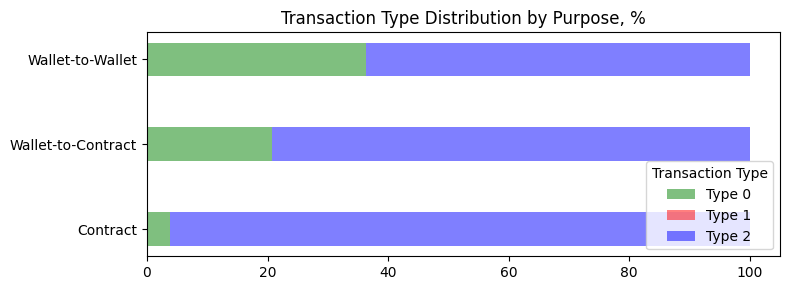

In [42]:
pivot_data = transactions_type_percentage.pivot(
    index='transactions_purpose', 
    columns='transaction_type', 
    values='percentage'
).fillna(0)

bar_height = 0.4
categories = pivot_data.index
types = pivot_data.columns
values = [pivot_data[t] for t in types]

plt.figure(figsize=(8, 3))
bars = plt.barh(categories, values[0], color='green', alpha=0.5, height=bar_height, label='Type 0')
bars = plt.barh(categories, values[1], left=values[0], color='red', alpha=0.5, height=bar_height, label='Type 1')
bars = plt.barh(categories, values[2], left=values[0] + values[1], color='blue', alpha=0.5, height=bar_height, label='Type 2')

plt.title('Transaction Type Distribution by Purpose, %')
plt.legend(title='Transaction Type', loc='lower right')
plt.tight_layout()

plt.show()

#### **Insights**
- **Contract Transactions**:
  - Dominated by Type 2 transactions, showing reliance on advanced functionality for contract-specific operations.
- **Wallet-to-Contract Transactions**:
  - Significant presence of Type 2 transactions reflects the dynamic nature of contract interactions.
- **Wallet-to-Wallet Transactions**:
  - While Type 2 is prevalent, a notable proportion of Type 0 transactions indicates the continued use of legacy transfers for simpler interactions.

### **12. What are the TOP-25 Contract Addresses?**

#### Objective:
Identify and categorize the top 25 contract addresses based on transaction counts and analyze their functionality.

#### Steps:
1. **Filter Transactions**:
   - Excluded simple transfers (`function != 'Transfer'`) and ensured valid contract interactions (`to_address != 'Contract'`).

2. **Identify Top 25 Contracts**:
   - Used `.value_counts()` to rank contract addresses by transaction count.
   - Collected the top 25 contracts with the highest transaction activity.

3. **Decode Contract Names**:
   - Created a dictionary `contract_dict` using **Etherscan** and **ChatGPT** to map addresses to their known owners or functionality (Api does not have information        about address's owners)

4. **Categorize Functionality**:
   - Defined the function `get_contract_functionality` to classify contracts into categories such as:
     - Stablecoin
     - Router
     - Bridge
     - Token (NFT)
     - Infrastructure
     - Other

5. **Visualization**:
   - Generated a horizontal bar chart to show the percentage distribution of the top 25 contracts by functionality.

In [43]:
top25_contracts = (
    df[(df['function'] != 'Transfer') & (df['to_address'] != 'Contract')]
    .to_address.value_counts()
    .head(25)
    .reset_index()
)

top25_contracts.columns = ['to_address', 'transaction_count']

In [44]:
top25_contracts.head(3)

,to_address,transaction_count
0,0xdac17f958d2ee523a2206206994597c13d831ec7,3128
1,0x32400084c286cf3e17e7b677ea9583e60a000324,859
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,735


In [45]:
contract_dict = {
    '0xdac17f958d2ee523a2206206994597c13d831ec7': 'USDT (Tether) coin',
    '0x32400084c286cf3e17e7b677ea9583e60a000324': 'zkSync: Layer 2 Bridge',
    '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 'USDC (USD Coin)',
    '0x881d4032abe4188e2237efcd27ab435e81fc6bb1': 'MetaMask Swap Router',
    '0xae0ee0a63a2ce6baeeffe56e7714fb4efe48d419': 'StarkGate ETH Bridge',
    '0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad': 'Uniswap: Universal Router',
    '0x95ad61b0a150d79219dcf64e1e6cc01f0b64c4ce': 'Shiba Inu (SHIB) token',
    '0xabea9132b05a70803a4e85094fd0e1800777fbef': 'zkSync: Layer 2 Bridge',
    '0x7a250d5630b4cf539739df2c5dacb4c659f2488d': 'Uniswap V2: Router 2',
    '0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b': 'Uniswap: Universal Router 2',
    '0x06450dee7fd2fb8e39061434babcfc05599a6fb8': 'XEN Crypto (XEN) token',
    '0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0': 'Matic Token (MATIC) token',
    '0x881d40237659c251811cec9c364ef91dc08d300c': 'MetaMask: Swap Router',
    '0x514910771af9ca656af840dff83e8264ecf986ca': 'ChainLink Token (LINK)',
    '0xdef1c0ded9bec7f1a1670819833240f027b25eff': '0x Protocol: Exchange Proxy',
    '0x00000000219ab540356cbb839cbe05303d7705fa': 'Beacon Deposit Contract',
    '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'Wrapped Ether (WETH) token',
    '0xe66b31678d6c16e9ebf358268a790b763c133750': '0x: Coinbase Wallet Proxy',
    '0x1a0ad011913a150f69f6a19df447a0cfd9551054': 'Zora: Bridge',
    '0xd4307e0acd12cf46fd6cf93bc264f5d5d1598792': 'Base, Introduced token',
    '0x6b175474e89094c44da98b954eedeac495271d0f': 'Dai Stablecoin (DAI)',
    '0x0000000000664ceffed39244a8312bd895470803': 'ENS: ETH Registrar Controller',
    '0x3506424f91fd33084466f402d5d97f05f8e3b4af': 'Chiliz (CHZ) token',
    '0xd19d4b5d358258f05d7b411e21a1460d11b0876f': 'Linea: L1 Message Service',
    '0x4d224452801aced8b2f0aebe155379bb5d594381': 'ApeCoin (APE) token'
}


In [46]:
top25_contracts['decoded_contracts'] = top25_contracts['to_address'].map(contract_dict)

In [47]:
def get_contract_functionality(decoded_contracts):
    """
    Categorizes a contract's functionality based on its decoded name.

    Args:
        decoded_contracts (str): The decoded name of the contract.

    Returns:
        str: The category of the contract's functionality, such as:
             - 'Stablecoin' for tokens like USDT or DAI.
             - 'Router' for Uniswap or similar protocols.
             - 'Bridge' for cross-chain bridge services.
             - 'Token (NFT)' for NFT-related smart contracts.
             - 'Infrastructure' for foundational blockchain services (e.g., ENS).
             - 'Other' for unclassified or less common functionalities.
    """
    if isinstance(decoded_contracts, str):
        decoded_contracts = decoded_contracts.lower()
        if 'tether' in decoded_contracts or 'usd coin' in decoded_contracts or 'dai' in decoded_contracts:
            return 'Stablecoin'
        elif 'uniswap' in decoded_contracts or 'metamask' in decoded_contracts:
            return 'Router'
        elif 'bridge' in decoded_contracts:
            return 'Bridge'
        elif 'token' in decoded_contracts:
            return 'Token (NFT)'
        elif 'ens' in decoded_contracts or 'proxy' in decoded_contracts or 'beacon' in decoded_contracts:
            return 'Infrastructure'
        else:
            return 'Other'
    return 'Other'


In [48]:
top25_contracts['contract_functionality'] = top25_contracts['decoded_contracts'].apply(get_contract_functionality)

In [49]:
top25_contracts.head(3)

,to_address,transaction_count,decoded_contracts,contract_functionality
0,0xdac17f958d2ee523a2206206994597c13d831ec7,3128,USDT (Tether) coin,Stablecoin
1,0x32400084c286cf3e17e7b677ea9583e60a000324,859,zkSync: Layer 2 Bridge,Bridge
2,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,735,USDC (USD Coin),Stablecoin


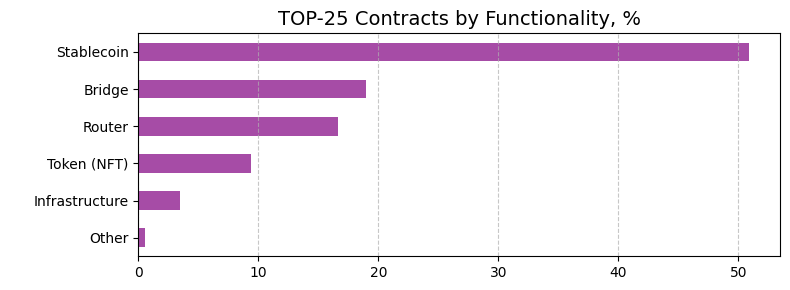

In [50]:
category_percentage = top25_contracts.groupby('contract_functionality')['transaction_count'].sum() / top25_contracts['transaction_count'].sum() * 100

plt.figure(figsize=(8, 3))
category_percentage.sort_values().plot(kind='barh', color='purple', alpha=0.7)

plt.title('TOP-25 Contracts by Functionality, %', fontsize=14)
plt.ylabel('  ', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### Results:
- **Stablecoins** dominate with ~50% of transactions.
- **Bridges** and **Routers** account for significant portions, reflecting the role of cross-chain interactions.
- Other categories, including **Tokens (NFTs)** and **Infrastructure**, represent smaller shares.

#### Conclusion:
The analysis reveals that most activity among the top 25 contracts involves stablecoins and infrastructure supporting cross-chain operations. This emphasizes the importance of these functionalities in Ethereum's ecosystem.


### **13. Statistical Analysis of Gas Difference Between Stablecoin and Token Contracts**

#### **Objective**:
Determine whether there is a statistically significant difference in the gas difference between stablecoin and token (NFT) contracts.

#### **13.1 Data Preparation**
1. **Filtered Data**:
   - Selected `Wallet-to-Contract` transactions with necessary columns: `to_address` and `gas_difference`.
   - Mapped `to_address` to their decoded names and classified functionality using the `get_contract_functionality` function.


In [51]:
user_to_contract_gas_diff = df[df['transactions_purpose'] == 'Wallet-to-Contract'][['to_address', 'gas_difference']]

2. **Separated Distributions**:
   - Extracted gas difference values for:
     - **Stablecoin Contracts**
     - **Token (NFT) Contracts**

**NOTE:**
For building a distribution each value in column 'gas_difference' is needed.  
As a contract_dict has only 25 identified addresses, unidentified addresses return NaN.  
It has no impact on the next research, so there is no need to handle it.

In [52]:
user_to_contract_gas_diff['decoded_contracts'] = user_to_contract_gas_diff['to_address'].map(contract_dict)
user_to_contract_gas_diff['contract_functionality'] = user_to_contract_gas_diff['decoded_contracts'].apply(get_contract_functionality)
user_to_contract_gas_diff.head(3)

,to_address,gas_difference,decoded_contracts,contract_functionality
0,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,19704,USDC (USD Coin),Stablecoin
1,0xdef1c0ded9bec7f1a1670819833240f027b25eff,31296,0x Protocol: Exchange Proxy,Infrastructure
2,0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9,90582,NaN,Other


Distinguishing gas difference distribution for stablecoin functionality contracts and token (NFT) functionality contracts:

In [53]:
stablecoin_distribution = (
    user_to_contract_gas_diff[(user_to_contract_gas_diff['contract_functionality'] == 'Stablecoin') 
    & (user_to_contract_gas_diff['gas_difference'] != 0)]
    .gas_difference
)

token_distribution = (
    user_to_contract_gas_diff[(user_to_contract_gas_diff['contract_functionality'] == 'Token (NFT)')
    & (user_to_contract_gas_diff['gas_difference'] != 0)]
    .gas_difference
)

#### **13.2 Visualizing Gas Difference Distributions**

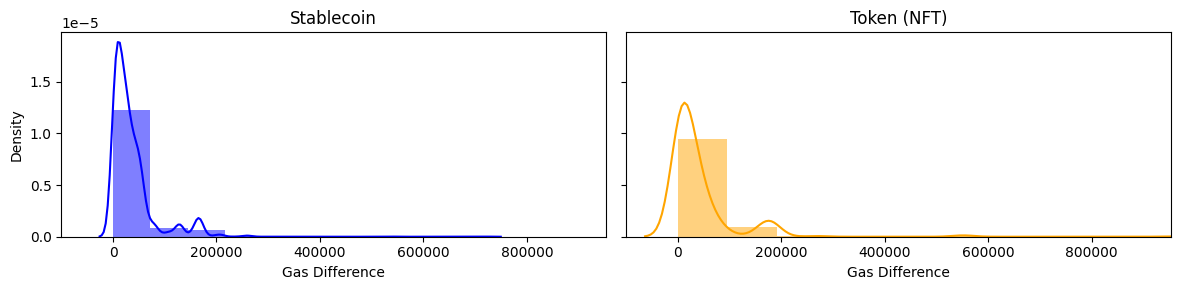

In [54]:
x_max = max(stablecoin_distribution.max(), token_distribution.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

axes[0].hist(stablecoin_distribution, bins=10, density=True, alpha=0.5, color='blue', label='Stablecoin')
sns.kdeplot(stablecoin_distribution, ax=axes[0], color='blue')
axes[0].set_title('Stablecoin')
axes[0].set_xlabel('Gas Difference')
axes[0].set_ylabel('Density')
axes[0].set_xlim(-100000, x_max)

axes[1].hist(token_distribution, bins=10, density=True, alpha=0.5, color='orange', label='Token (NFT)')
sns.kdeplot(token_distribution, ax=axes[1], color='orange')
axes[1].set_title('Token (NFT)')
axes[1].set_xlabel('Gas Difference')
axes[1].set_xlim(-100000, x_max)

plt.tight_layout()
plt.show()


#### **Kernel Dencity Estimation (KDE) Plot of Gas Difference**

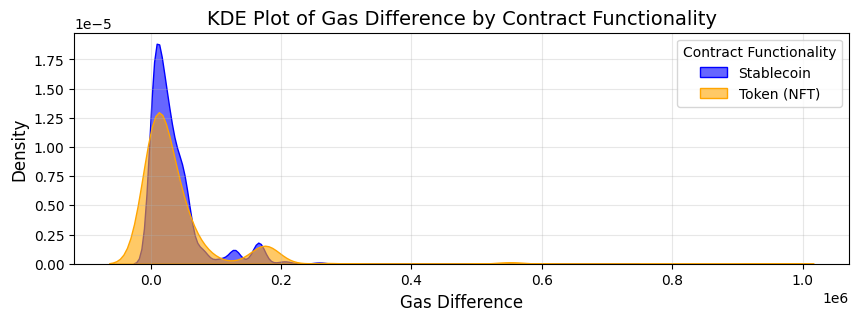

In [55]:
plt.figure(figsize=(10, 3))
sns.kdeplot(stablecoin_distribution, label='Stablecoin', fill=True, alpha=0.6, color='blue')
sns.kdeplot(token_distribution, label='Token (NFT)', fill=True, alpha=0.6, color='orange')

plt.title("KDE Plot of Gas Difference by Contract Functionality", fontsize=14)
plt.xlabel("Gas Difference", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(title="Contract Functionality", fontsize=10)
plt.grid(True, alpha=0.3)

plt.show()

**Despite the visual similarity of the KDE Plot of Gas Difference, a statistical test is required to confirm or refute the hypothesis.**  
**Distributions are not normall, so let's try to normalize them.**

#### **13.3 Handling Outliers**

1. **IQR Method**:
   - Applied the Interquartile Range (IQR) method to remove outliers, as it is less sensitive compared to the 3*STD method.

2. **Log Transformation**:
   - Performed log transformation on both distributions to stabilize variance.

**Stablecoin Distribution**

In [56]:
Q1 = stablecoin_distribution.quantile(0.25)
Q3 = stablecoin_distribution.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

stablecoin_distribution = stablecoin_distribution[(stablecoin_distribution >= lower_bound) & (stablecoin_distribution <= upper_bound)]

**Token (NFT) Distribution**

In [57]:
Q1 = token_distribution.quantile(0.25)
Q3 = token_distribution.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

token_distribution = token_distribution[(token_distribution >= lower_bound) & (token_distribution <= upper_bound)]

**Normalizing the Stablecoin and Token (NFT) Gas Difference Distributions**

In [58]:
stablecoin_distribution_log = np.log1p(stablecoin_distribution)
token_distribution_log = np.log1p(token_distribution)

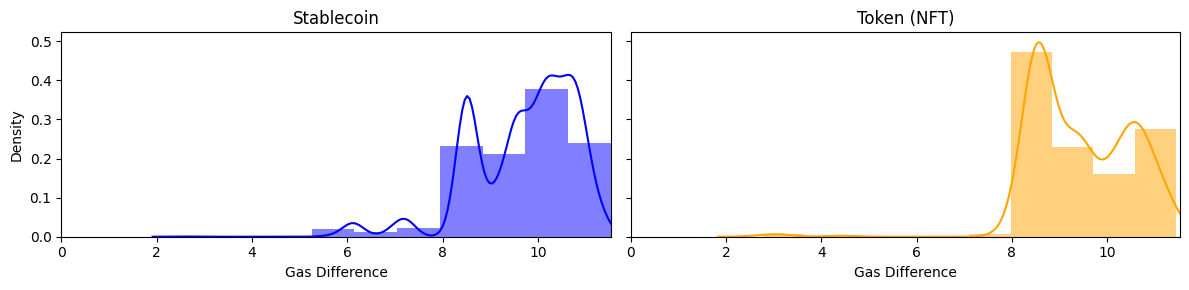

In [59]:
x_max = max(stablecoin_distribution_log.max(), token_distribution_log.max())

fig, axes = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

axes[0].hist(stablecoin_distribution_log, bins=10, density=True, alpha=0.5, color='blue', label='Stablecoin')
sns.kdeplot(stablecoin_distribution_log, ax=axes[0], color='blue')
axes[0].set_title('Stablecoin')
axes[0].set_xlabel('Gas Difference')
axes[0].set_ylabel('Density')
axes[0].set_xlim(0, x_max)

axes[1].hist(token_distribution_log, bins=10, density=True, alpha=0.5, color='orange', label='Token (NFT)')
sns.kdeplot(token_distribution_log, ax=axes[1], color='orange')
axes[1].set_title('Token (NFT)')
axes[1].set_xlabel('Gas Difference')
axes[1].set_xlim(0, x_max)

plt.tight_layout()
plt.show()


**Results**:
   - Despite the transformation, the distributions remained non-normal.

Since the log-transformed distributions did not become normal, use the **Mann-Whitney test** for the statistical analysis.

#### **13.4 Statistical Hypotheses**
- **Null Hypothesis (H₀)**:
  - Gas differences for stablecoin and token contracts are the same.
  - No statistically significant difference exists between the two groups.
- **Alternative Hypothesis (H₁)**:
  - Gas differences for stablecoin and token contracts are different.
  - One type systematically overestimates or underestimates gas usage compared to the other.

#### **13.5 Statistical Test**
- Used the **Mann-Whitney U Test** (a non-parametric test) due to the non-normality of distributions.

In [60]:
stat, p_value = mannwhitneyu(stablecoin_distribution, token_distribution, alternative='two-sided')

print(f"U-Statistic: {stat}")
print(f"P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("Reject H₀: There is a statistically significant difference between the groups.")
else:
    print("fFail to reject H₀: There is no statistically significant difference between the groups.")

U-Statistic: 1032795.0
P-Value: 5.574554723823791e-10
Reject H₀: There is a statistically significant difference between the groups.


#### **13.6 Mean and Median Analysis**


In [61]:
stablecoin_distribution.mean(), stablecoin_distribution.median()

(np.float64(24897.804392994953), np.float64(21012.0))

In [62]:
token_distribution.mean(), token_distribution.median()

(np.float64(20757.908571428572), np.float64(11759.0))

- **Stablecoin Contracts**:
  - Mean: 24,632
  - Median: 21,012
- **Token Contracts**:
  - Mean: 20,757
  - Median: 11,759

**Conclusion**:
- Stablecoin contracts tend to overestimate gas requirements compared to token contracts, as indicated by higher mean and median gas differences.
- Token contracts provide more accurate gas estimations, with smaller discrepancies between estimated and actual gas usage.

### **Conclusion**

This analysis provides an in-depth exploration of Ethereum's transactional behavior, with a focus on newly created wallets, gas usage, and interactions with smart contracts. The key findings are:

1. **New Wallet Behavior**:
   - The majority of first transactions from new wallets involve **interactions with contracts** (Wallet-to-Contract transactions), while a significant portion represents direct Wallet-to-Wallet transfers. Contract-initiated transactions remain rare among new accounts.

2. **Transaction Value Distribution**:
   - Wallet-to-Wallet transactions exhibit a broader range of values, from micro-transfers to large-scale transfers, reflecting diverse use cases. In contrast, Wallet-to-Contract transactions often involve zero or minimal value, emphasizing their non-monetary, instructional nature.

3. **Gas Usage Insights**:
   - **Wallet-to-Wallet transactions** show predictable gas usage with minimal variability, reflecting their simplicity.
   - **Wallet-to-Contract transactions** exhibit greater variability, indicating the complexity of contract interactions.
   - **Contract transactions** consume the highest gas, reflecting their multitasking nature.

4. **Contract Analysis**:
   - Among the top 25 contract addresses, **stablecoins** dominate, followed by **bridges** and **routers**, highlighting the importance of DeFi and cross-chain functionality within Ethereum's ecosystem.

5. **Statistical Analysis of Gas Difference**:
   - Stablecoin contracts tend to overestimate gas requirements compared to token contracts, as revealed by statistically significant differences in gas discrepancies. Token contracts demonstrate more consistent and accurate gas estimation.

### **Overall Implications**:
- The Ethereum ecosystem's diversity is evident in the range of transaction types, values, and gas usage patterns.
- Smart contract interactions dominate new wallet activity, with cross-chain applications driving most activity.
- Stablecoin contracts, despite their importance, may require further optimization in gas estimation to reduce overestimation and enhance efficiency.